The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 957 kB/s 
     |████████████████████████████████| 120 kB 36.4 MB/s 
     |████████████████████████████████| 1.6 MB 42.8 MB/s 
     |████████████████████████████████| 82 kB 832 kB/s 


# Anchor Boxes
:label:`sec_anchor`


Object detection algorithms usually
sample a large number of regions in the input image, determine whether these regions contain
objects of interest, and adjust the boundaries
of the regions so as to predict the
*ground-truth bounding boxes*
of the objects more accurately.
Different models may adopt
different region sampling schemes. 
Here we introduce one of such methods:
it generates multiple bounding boxes with varying scales and aspect ratios centered on each pixel. 
These bounding boxes are called *anchor boxes*.
We will design an object detection model
based on anchor boxes in :numref:`sec_ssd`.

First, let's modify the printing accuracy
just for more concise outputs.


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # Simplify printing accuracy

## Generating Multiple Anchor Boxes

Suppose that the input image has a height of $h$ and width of $w$. 
We generate anchor boxes with different shapes centered on each pixel of the image.
Let the *scale* be $s\in (0, 1]$ and
the *aspect ratio* (ratio of width to height) is $r > 0$. 
Then [**the width and height of the anchor box are $ws\sqrt{r}$ and $hs/\sqrt{r}$, respectively.**]
Note that when the center position is given, an anchor box with known width and height is determined.

To generate multiple anchor boxes with different shapes,
let's set a series of scales
$s_1,\ldots, s_n$ and 
a series of aspect ratios $r_1,\ldots, r_m$.
When using all the combinations of these scales and aspect ratios with each pixel as the center,
the input image will have a total of $whnm$ anchor boxes. Although these anchor boxes may cover all the
ground-truth bounding boxes, the computational complexity is easily too high.
In practice,
we can only (**consider those combinations
containing**) $s_1$ or $r_1$:

(**$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$**)

That is to say, the number of anchor boxes centered on the same pixel is $n+m-1$. For the entire input image, we will generate a total of $wh(n+m-1)$ anchor boxes.

The above method of generating anchor boxes is implemented in the following `multibox_prior` function. We specify the input image, a list of scales, and a list of aspect ratios, then this function will return all the anchor boxes.


In [3]:
#@save
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

We can see that [**the shape of the returned anchor box variable `Y`**] is
(batch size, number of anchor boxes, 4).


In [4]:
img = d2l.plt.imread('1.jpg')
h, w = img.shape[:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))  # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

472 800


torch.Size([1, 1888000, 4])

After changing the shape of the anchor box variable `Y` to (image height, image width, number of anchor boxes centered on the same pixel, 4),
we can obtain all the anchor boxes centered on a specified pixel position.
In the following,
we [**access the first anchor box centered on (250, 250)**]. It has four elements: the $(x, y)$-axis coordinates at the upper-left corner and the $(x, y)$-axis coordinates at the lower-right corner of the anchor box.
The coordinate values of both axes
are divided by the width and height of the image, respectively; thus, the range is between 0 and 1.


In [5]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.09, 0.16, 0.53, 0.91])

In order to [**show all the anchor boxes centered on one pixel in the image**],
we define the following `show_bboxes` function to draw multiple bounding boxes on the image.


In [6]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

As we just saw, the coordinate values of the $x$ and $y$ axes in the variable `boxes` have been divided by the width and height of the image, respectively.
When drawing anchor boxes,
we need to restore their original coordinate values;
thus, we define variable `bbox_scale` below. 
Now, we can draw all the anchor boxes centered on (250, 250) in the image.
As you can see, the blue anchor box with a scale of 0.75 and an aspect ratio of 1 well
surrounds the dog in the image.


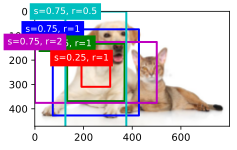

In [7]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

## [**Intersection over Union (IoU)**]

We just mentioned that an anchor box "well" surrounds the dog in the image.
If the ground-truth bounding box of the object is known, how can "well" here be quantified?
Intuitively, we can measure the similarity between
the anchor box and the ground-truth bounding box.
We know that the *Jaccard index* can measure the similarity between two sets. Given sets $\mathcal{A}$ and $\mathcal{B}$, their Jaccard index is the size of their intersection divided by the size of their union:

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$


In fact, we can consider the pixel area of any bounding box as a set of pixels. 
In this way, we can measure the similarity of the two bounding boxes by the Jaccard index of their pixel sets. For two bounding boxes, we usually refer their Jaccard index as *intersection over union* (*IoU*), which is the ratio of their intersection area to their union area, as shown in :numref:`fig_iou`.
The range of an IoU is between 0 and 1:
0 means that two bounding boxes do not overlap at all,
while 1 indicates that the two bounding boxes are equal.

![IoU is the ratio of the intersection area to the union area of two bounding boxes.](http://d2l.ai/_images/iou.svg)
:label:`fig_iou`

For the remainder of this section, we will use IoU to measure the similarity between anchor boxes and ground-truth bounding boxes, and between different anchor boxes.
Given two lists of anchor or bounding boxes,
the following `box_iou` computes their pairwise IoU
across these two lists.


In [8]:
#@save
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

## Labeling Anchor Boxes in Training Data
:label:`subsec_labeling-anchor-boxes`


In a training dataset,
we consider each anchor box as a training example.
In order to train an object detection model,
we need *class* and *offset* labels for each anchor box,
where the former is
the class of the object relevant to the anchor box
and the latter is the offset
of the ground-truth bounding box relative to the anchor box.
During the prediction,
for each image
we generate multiple anchor boxes,
predict classes and offsets for all the anchor boxes,
adjust their positions according to the predicted offsets to obtain the predicted bounding boxes,
and finally only output those 
predicted bounding boxes that satisfy certain criteria.


As we know, an object detection training set
comes with labels for
locations of *ground-truth bounding boxes*
and classes of their surrounded objects.
To label any generated *anchor box*,
we refer to the labeled
location and class of its *assigned* ground-truth bounding box that is closest to the anchor box.
In the following,
we describe an algorithm for assigning
closest ground-truth bounding boxes to anchor boxes. 

### [**Assigning Ground-Truth Bounding Boxes to Anchor Boxes**]

Given an image,
suppose that the anchor boxes are $A_1, A_2, \ldots, A_{n_a}$ and the ground-truth bounding boxes are $B_1, B_2, \ldots, B_{n_b}$, where $n_a \geq n_b$.
Let's define a matrix $\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$, whose element $x_{ij}$ in the $i^\mathrm{th}$ row and $j^\mathrm{th}$ column is the IoU of the anchor box $A_i$ and the ground-truth bounding box $B_j$. The algorithm consists of the following steps:

1. Find the largest element in matrix $\mathbf{X}$ and denote its row and column indices as $i_1$ and $j_1$, respectively. Then the ground-truth bounding box $B_{j_1}$ is assigned to the anchor box $A_{i_1}$. This is quite intuitive because $A_{i_1}$ and $B_{j_1}$ are the closest among all the pairs of anchor boxes and ground-truth bounding boxes. After the first assignment, discard all the elements in the ${i_1}^\mathrm{th}$ row and the ${j_1}^\mathrm{th}$ column in matrix $\mathbf{X}$. 
1. Find the largest of the remaining elements in matrix $\mathbf{X}$ and denote its row and column indices as $i_2$ and $j_2$, respectively. We assign ground-truth bounding box $B_{j_2}$ to anchor box $A_{i_2}$ and discard all the elements in the ${i_2}^\mathrm{th}$ row and the ${j_2}^\mathrm{th}$ column in matrix $\mathbf{X}$.
1. At this point, elements in two rows and two columns in  matrix $\mathbf{X}$ have been discarded. We proceed until all elements in $n_b$ columns in matrix $\mathbf{X}$ are discarded. At this time, we have assigned a ground-truth bounding box to each of $n_b$ anchor boxes.
1. Only traverse through the remaining $n_a - n_b$ anchor boxes. For example, given any anchor box $A_i$, find the ground-truth bounding box $B_j$ with the largest IoU with $A_i$ throughout the $i^\mathrm{th}$ row of matrix $\mathbf{X}$, and assign $B_j$ to $A_i$ only if this IoU is greater than a predefined threshold.

Let's illustrate the above algorithm using a concrete
example.
As shown in :numref:`fig_anchor_label` (left), assuming that the maximum value in matrix $\mathbf{X}$ is $x_{23}$, we assign the ground-truth bounding box $B_3$ to the anchor box $A_2$.
Then, we discard all the elements in row 2 and column 3 of the matrix, find the largest $x_{71}$ in the remaining  elements (shaded area), and assign the ground-truth bounding box $B_1$ to the anchor box $A_7$. 
Next, as shown in :numref:`fig_anchor_label` (middle), discard all the elements in row 7 and column 1 of the matrix, find the largest $x_{54}$ in the remaining  elements (shaded area), and assign the ground-truth bounding box $B_4$ to the anchor box $A_5$. 
Finally, as shown in :numref:`fig_anchor_label` (right), discard all the elements in row 5 and column 4 of the matrix, find the largest $x_{92}$ in the remaining elements (shaded area), and assign the ground-truth bounding box $B_2$ to the anchor box $A_9$.
After that, we only need to traverse through
the remaining anchor boxes $A_1, A_3, A_4, A_6, A_8$ and determine whether to assign them ground-truth bounding boxes according to the threshold.

![Assigning ground-truth bounding boxes to anchor boxes.](https://github.com/d2l-ai/d2l-pytorch-colab/blob/master/img/anchor-label.svg?raw=1)
:label:`fig_anchor_label`

This algorithm is implemented in the following `assign_anchor_to_bbox` function.


In [9]:
#@save
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

### Labeling Classes and Offsets

Now we can label the class and offset for each anchor box. Suppose that an anchor box $A$ is assigned
a ground-truth bounding box $B$. 
On the one hand,
the class of the anchor box $A$ will be
labeled as that of $B$.
On the other hand,
the offset of the anchor box $A$ 
will be labeled according to the 
relative position between
the central coordinates of $B$ and $A$
together with the relative size between
these two boxes.
Given varying
positions and sizes of different boxes in the dataset,
we can apply transformations
to those relative positions and sizes
that may lead to 
more uniformly distributed offsets
that are easier to fit.
Here we describe a common transformation.
[**Given the central coordinates of $A$ and $B$ as $(x_a, y_a)$ and $(x_b, y_b)$, 
their widths as $w_a$ and $w_b$, 
and their heights as $h_a$ and $h_b$, respectively. 
We may label the offset of $A$ as

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$
**]
where default values of the constants are $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$, and $\sigma_w=\sigma_h=0.2$.
This transformation is implemented below in the `offset_boxes` function.


In [10]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

If an anchor box is not assigned a ground-truth bounding box, we just label the class of the anchor box as "background".
Anchor boxes whose classes are background are often referred to as *negative* anchor boxes,
and the rest are called *positive* anchor boxes.
We implement the following `multibox_target` function
to [**label classes and offsets for anchor boxes**] (the `anchors` argument) using ground-truth bounding boxes (the `labels` argument).
This function sets the background class to zero and increments the integer index of a new class by one.


In [11]:
#@save
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

### An Example

Let's illustrate anchor box labeling
via a concrete example.
We define ground-truth bounding boxes for the dog and cat in the loaded image,
where the first element is the class (0 for dog and 1 for cat) and the remaining four elements are the
$(x, y)$-axis coordinates
at the upper-left corner and the lower-right corner
(range is between 0 and 1). 
We also construct five anchor boxes to be labeled
using the coordinates of
the upper-left corner and the lower-right corner:
$A_0, \ldots, A_4$ (the index starts from 0).
Then we [**plot these ground-truth bounding boxes 
and anchor boxes 
in the image.**]


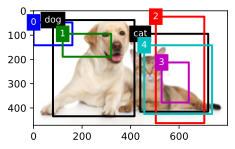

In [12]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

Using the `multibox_target` function defined above,
we can [**label classes and offsets
of these anchor boxes based on
the ground-truth bounding boxes**] for the dog and cat.
In this example, indices of
the background, dog, and cat classes
are 0, 1, and 2, respectively. 
Below we add an dimension for examples of anchor boxes and ground-truth bounding boxes.


In [13]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

There are three items in the returned result, all of which are in the tensor format.
The third item contains the labeled classes of the input anchor boxes.

Let's analyze the returned class labels below based on
anchor box and ground-truth bounding box positions in the image.
First, among all the pairs of anchor boxes
and ground-truth bounding boxes,
the IoU of the anchor box $A_4$ and the ground-truth bounding box of the cat is the largest. 
Thus, the class of $A_4$ is labeled as the cat.
Taking out 
pairs containing $A_4$ or the ground-truth bounding box of the cat, among the rest 
the pair of the anchor box $A_1$ and the ground-truth bounding box of the dog has the largest IoU.
So the class of $A_1$ is labeled as the dog.
Next, we need to traverse through the remaining three unlabeled anchor boxes: $A_0$, $A_2$, and $A_3$.
For $A_0$,
the class of the ground-truth bounding box with the largest IoU is the dog,
but the IoU is below the predefined threshold (0.5),
so the class is labeled as background;
for $A_2$,
the class of the ground-truth bounding box with the largest IoU is the cat and the IoU exceeds the threshold, so the class is labeled as the cat;
for $A_3$,
the class of the ground-truth bounding box with the largest IoU is the cat, but the value is below the threshold, so the class is labeled as background.


In [14]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

The second returned item is a mask variable of the shape (batch size, four times the number of anchor boxes).
Every four elements in the mask variable 
correspond to the four offset values of each anchor box.
Since we do not care about background detection,
offsets of this negative class should not affect the objective function.
Through elementwise multiplications, zeros in the mask variable will filter out negative class offsets before calculating the objective function.


In [15]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

The first returned item contains the four offset values labeled for each anchor box.
Note that the offsets of negative-class anchor boxes are labeled as zeros.


In [16]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

## Predicting Bounding Boxes with Non-Maximum Suppression
:label:`subsec_predicting-bounding-boxes-nms`

During prediction,
we generate multiple anchor boxes for the image and predict classes and offsets for each of them.
A *predicted bounding box*
is thus obtained according to 
an anchor box with its predicted offset.
Below we implement the `offset_inverse` function
that takes in anchors and
offset predictions as inputs and [**applies inverse offset transformations to
return the predicted bounding box coordinates**].


In [17]:
#@save
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

When there are many anchor boxes,
many similar (with significant overlap)
predicted bounding boxes 
can be potentially output for surrounding the same object.
To simplify the output,
we can merge similar predicted bounding boxes
that belong to the same object
by using *non-maximum suppression* (NMS).

Here is how non-maximum suppression works.
For a predicted bounding box $B$,
the object detection model calculates the predicted likelihood
for each class.
Denoting by $p$ the largest predicted likelihood,
the class corresponding to this probability is the predicted class for $B$.
Specifically, we refer to $p$ as the *confidence* (score) of the predicted bounding box $B$.
On the same image,
all the predicted non-background bounding boxes 
are sorted by confidence in descending order
to generate a list $L$.
Then we manipulate the sorted list $L$ in the following steps:

1. Select the predicted bounding box $B_1$ with the highest confidence from $L$ as a basis and remove all non-basis predicted bounding boxes whose IoU with $B_1$ exceeds a predefined threshold $\epsilon$ from $L$. At this point, $L$ keeps the predicted bounding box with the highest confidence but drops others that are too similar to it. In a nutshell, those with *non-maximum* confidence scores are *suppressed*.
1. Select the predicted bounding box $B_2$ with the second highest confidence from $L$ as another basis and remove all non-basis predicted bounding boxes whose IoU with $B_2$ exceeds $\epsilon$ from $L$.
1. Repeat the above process until all the predicted bounding boxes in $L$ have been used as a basis. At this time, the IoU of any pair of predicted bounding boxes in $L$ is below the threshold $\epsilon$; thus, no pair is too similar with each other. 
1. Output all the predicted bounding boxes in the list $L$.

[**The following `nms` function sorts confidence scores in descending order and returns their indices.**]


In [18]:
#@save
def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

We define the following `multibox_detection`
to [**apply non-maximum suppression
to predicting bounding boxes**].
Do not worry if you find the implementation
a bit complicated: we will show how it works
with a concrete example right after the implementation.


In [19]:
#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

Now let's [**apply the above implementations
to a concrete example with four anchor boxes**].
For simplicity, we assume that the
predicted offsets are all zeros.
This means that the predicted bounding boxes are anchor boxes. 
For each class among the background, dog, and cat,
we also define its predicted likelihood.


In [20]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted background likelihood
                      [0.9, 0.8, 0.7, 0.1],  # Predicted dog likelihood
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted cat likelihood

We can [**plot these predicted bounding boxes with their confidence on the image.**]


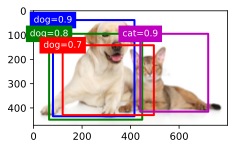

In [21]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

Now we can invoke the `multibox_detection` function
to perform non-maximum suppression,
where the threshold is set to 0.5.
Note that we add
a dimension for examples in the tensor input.

We can see that [**the shape of the returned result**] is
(batch size, number of anchor boxes, 6).
The six elements in the innermost dimension
gives the output information for the same predicted bounding box.
The first element is the predicted class index, which starts from 0 (0 is dog and 1 is cat). The value -1 indicates background or removal in non-maximum suppression.
The second element is the confidence of the predicted bounding box.
The remaining four elements are the $(x, y)$-axis coordinates of the upper-left corner and 
the lower-right corner of the predicted bounding box, respectively (range is between 0 and 1).


In [22]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

After removing those predicted bounding boxes
of class -1, 
we can [**output the final predicted bounding box
kept by non-maximum suppression**].


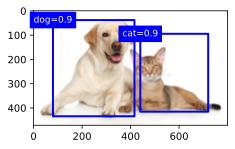

In [23]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

In practice, we can remove predicted bounding boxes with lower confidence even before performing non-maximum suppression, thereby reducing computation in this algorithm.
We may also post-process the output of non-maximum suppression, for example, by only keeping
results with higher confidence
in the final output.


## Summary

* We generate anchor boxes with different shapes centered on each pixel of the image.
* Intersection over union (IoU), also known as Jaccard index, measures the similarity of two bounding boxes. It is the ratio of their intersection area to their union area.
* In a training set, we need two types of labels for each anchor box. One is the class of the object relevant to the anchor box and the other is the offset of the ground-truth bounding box relative to the anchor box.
* During prediction, we can use non-maximum suppression (NMS) to remove similar predicted bounding boxes, thereby simplifying the output.


## Exercises

1. Change values of `sizes` and `ratios` in the `multibox_prior` function. What are the changes to the generated anchor boxes?
1. Construct and visualize two bounding boxes with an IoU of 0.5. How do they overlap with each other?
1. Modify the variable `anchors` in :numref:`subsec_labeling-anchor-boxes` and :numref:`subsec_predicting-bounding-boxes-nms`. How do the results change?
1. Non-maximum suppression is a greedy algorithm that suppresses predicted bounding boxes by *removing* them. Is it possible that some of these removed ones are actually useful? How can this algorithm be modified to suppress *softly*? You may refer to Soft-NMS :cite:`Bodla.Singh.Chellappa.ea.2017`.
1. Rather than being hand-crafted, can non-maximum suppression be learned?


[Discussions](https://discuss.d2l.ai/t/1603)
